In [11]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
from math import *
from sklearn import *
import pandas as pd
import re
import unicodedata
import string
import random
from collections import Counter
from numpy import linalg as alg
import os
#Lettres de l'alphabet
letters_space = list(string.ascii_lowercase)
letters_space.insert(26," ") 

Les données que nous avons utilisés pour constituer la base de textes provient de différents sources et sont de différentes natures. Allant des oeuvres philosophique, au poèmes en passant par des discours politique. On a pour chaque langues 20 textes de tailles variables. Ces textes sont stockés dans des fichiers. Les lignes de codes suivantes recupèrent le contenus de .txt et les stockent sous forme de dictionnaires en fonctions de langues. 

In [12]:
data = {'francais' : [],
     'anglais' : []}
test_data = {'francais' : [],
     'anglais' : []}

for dirname, _, filenames in os.walk('/home/unclevhins/projet_UL'):
    #print(dirname)
    for filename in filenames:
        #print(dirname)
    #print(os.path.join(dirname, filename))
        if os.path.exists(os.path.join(dirname, filename)):
            #print(dirname)
            if (dirname == '/home/unclevhins/projet_UL/anglais'):
                data['anglais'].append(open(os.path.join(dirname, filename), "rt").read())
            elif dirname == '/home/unclevhins/projet_UL/francais':
                data['francais'].append(open(os.path.join(dirname, filename), "rt").read())
            elif dirname == '/home/unclevhins/projet_UL/test_data/francais':
                test_data['francais'].append(open(os.path.join(dirname, filename), "rt").read())
            elif dirname == '/home/unclevhins/projet_UL/test_data/Anglais':
                test_data['anglais'].append(open(os.path.join(dirname, filename), "rt").read())

## conversion des dictionnaires en dataframe
df_texte = pd.DataFrame(data)
df_texte_test = pd.DataFrame(test_data)

## reangement de l'ordre de texte de telle sorte à avoir 20 textes en francais suivi de 20 textes francais.
## creation des colonnes langues et label (label = -1 si Anglais et label = 1 si Francais)
liste_texte = pd.DataFrame()
liste_texte_test = pd.DataFrame()

liste_texte['textes'] = df_texte['francais'].append(df_texte['anglais'])
liste_texte['label'] = np.repeat([1,-1],df_texte.shape[0])
liste_texte['lang'] = np.repeat(['Francais','Anglais'],df_texte.shape[0])
liste_texte.reset_index(drop=True, inplace=True)

liste_texte_test['textes'] = df_texte_test['francais'].append(df_texte_test['anglais'])
liste_texte_test['label'] = np.repeat([1,-1],df_texte_test.shape[0])
liste_texte_test['lang'] = np.repeat(['Francais','Anglais'],df_texte_test.shape[0])
liste_texte_test.reset_index(drop=True, inplace=True)


In [13]:
df_texte

,francais,anglais
0,Je ne sais si je dois vous entretenir des prem...,I stomp through the frostbitten door\nand your...
1,Toujours et Jamais étaient toujours ensemble\n...,the credits font crumbles to a song\na whole g...
2,Les mécanismes qui régissent le climat d’une p...,Suppose you spill lime soda\ndown the pulsitro...
3,Un village écoute désolé\nLe chant d'un oiseau...,"You do not do, you do not do\nAny more, black ..."
4,"La trompe de l’éléphant,\nc’est pour ramasser ...","Something bubbles from deep within the chest, ..."
5,C’est un réel plaisir pour moi de me trouver a...,"Dear reader,\nThe poems that follow are a few ..."
6,"Sur une planète inconnue,\nun cosmonaute renco...",Forty-five degrees and equidistant from where ...
7,Au bout du petit matin bourgeonnant d'anses fr...,The Only White Landscape is an assembly point....
8,"Demain, dès l'aube, à l'heure où blanchit la\n...",This book was written over two hundred years. ...
9,"Les chefs qui, depuis de nombreuses années, so...",There’s nothing to shatter\non this evening. T...


In [14]:
liste_texte.head(5)

,textes,label,lang
0,Je ne sais si je dois vous entretenir des prem...,1,Francais
1,Toujours et Jamais étaient toujours ensemble\n...,1,Francais
2,Les mécanismes qui régissent le climat d’une p...,1,Francais
3,Un village écoute désolé\nLe chant d'un oiseau...,1,Francais
4,"La trompe de l’éléphant,\nc’est pour ramasser ...",1,Francais


## **EXERCICE N°1**

Objectif de notre projet est travailler sur la compréhension et l'implementation de quelques méthodes de classication.

#### **1. Dans premier Exercice nous allons importer un texte dans lequel il y a un passage en Anglais et un autre passage en Français.**
Tout d'abord nous importons les bibliothèques qu'on utilisera par la suite.

In [15]:
def transTokeNorm(textes, ponctuation = True, accents = True, chiffres = True, ajoutespace = None):
    import re
    """
    Transforme Tokenize et normalise
    INPUT
    -----
    textes: type = 'string',
        la base de texte à traiter
    accent: type = boolean, 
        Indique si les symboles accents doivent être transformé ou non.
        False
        True
    chiffres: type = 'boolean',
        Renseigne la suppression ou non des chiffres dans le texte. 
        
    ajoutespace: type = 'str', 
        'f': ajout d'espace à la fin de la chaine
        'd': ajout d'espace au début de la chaine
    OUPUT
    -----
    res: type = 'string',
        la chaine résultante du processus.
    """
    
    if type(textes) == str:
        textes = pd.DataFrame(np.array([textes]))
        
    txt = "".join(textes.values.reshape(-1).tolist()).lower() 
    if(ponctuation & chiffres):#Si on veut enlever les ponctuations et les chiffres
        patterns = '[0-9"[,.?!''-\]"]'; #print("here")
    elif (ponctuation): #Si on veut enlever uniquement les ponctuations.
         patterns = '["[,.?!''-\]"]';  #print("here")
    elif (chiffres):#Pour supprimer juste les chiffres.
        patterns = '[0-9]'
    txt = re.sub(patterns, '', txt)
    to_remove = ["\n","’","–","‘","²","«","»","…","—","―","“","”","‖"]   
    for i in to_remove:
        txt = re.sub(i, " ", txt)
    
    if(accents):
        transTable = txt.maketrans("éêèâàîûôçœùíñï", "eeeaaiuocouini")
        txt = txt.translate(transTable)
    res = [i for i in txt]
    if (ajoutespace == "f"):
        res =  res + [" "]
    elif (ajoutespace == "d"):
        res =  [" "] + res
    return res

In [16]:
def freqUnigrams(text, ponctuation = True, accents = True, chiffres = True):
    unigrams = Counter(transTokeNorm(text))
    freq = pd.DataFrame(np.ones((1,27)),columns = letters_space)
    for letter in letters_space:
        freq[letter] = unigrams[letter] + 1
    return freq.apply(lambda x: x/np.sum(x), axis=1)

In [17]:
def matriceX(text, ponctuation = True, accents = True, chiffres = True):
    n = len(text)
    #text = pd.DataFrame(text)
    frequence = np.zeros((n, 27),  dtype = float) 
    for j in range(n) : 
        frequence[j,:] = freqUnigrams(text.iloc[j], ponctuation = True, accents = True, chiffres = True).values
    return np.log(1 + frequence)

In [18]:
freqUnigrams(df_texte['francais'].to_frame())

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
0,0.062709,0.007044,0.025001,0.026935,0.146103,0.009082,0.006457,0.006147,0.057702,0.005905,...,0.056114,0.070548,0.059843,0.055354,0.012259,0.000069,0.003902,0.002417,0.001347,0.179875


In [19]:
freqUnigrams(df_texte['anglais'].to_frame())

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
0,0.062137,0.012689,0.020922,0.031189,0.098702,0.019372,0.01821,0.043055,0.057633,0.001501,...,0.04906,0.056906,0.074777,0.025814,0.007458,0.017096,0.001162,0.017726,0.00063,0.187137


#### **2. Construction de tableau $X = (x_{ij})_{i = 1,...,n ; i = 1,...,p }$ appelé ici `X_ij` tel que $x_{ij} = \log(1+ f_{ij})$. $f_{ij}$ étant la fréquence du symbole $j$ dans le texte $i$.**

In [20]:
X_ij =  matriceX(liste_texte['textes'].to_frame())
X_ij  = pd.DataFrame(X_ij)
X_ij.columns = letters_space
#res.apply(sum,axis=1)
X_ij.head(10)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
0,0.058404,0.004287,0.017976,0.017507,0.132994,0.012334,0.006186,0.006660,0.062896,0.014689,...,0.042977,0.082866,0.057503,0.061102,0.010919,0.000477,0.001907,0.003336,0.000954,0.157350
1,0.080680,0.010595,0.024548,0.016432,0.090457,0.002364,0.005900,0.003544,0.069703,0.019919,...,0.058604,0.077399,0.073008,0.064169,0.009423,0.001183,0.004723,0.002364,0.001183,0.155333
2,0.064925,0.007474,0.027852,0.038100,0.141717,0.010099,0.011845,0.005721,0.046981,0.001764,...,0.059118,0.059949,0.052440,0.047402,0.006159,0.000882,0.005721,0.004403,0.002204,0.162563
3,0.067304,0.005051,0.026235,0.025001,0.145798,0.008822,0.011328,0.013828,0.060178,0.008822,...,0.042138,0.061369,0.061369,0.049393,0.017566,0.001265,0.001265,0.001265,0.001265,0.169583
4,0.064661,0.019456,0.034753,0.029044,0.132303,0.005877,0.003922,0.013659,0.038540,0.001963,...,0.057268,0.068338,0.044195,0.036648,0.013659,0.001963,0.003922,0.001963,0.001963,0.181011
5,0.061607,0.004065,0.027718,0.036789,0.137546,0.010535,0.008921,0.005686,0.057769,0.005686,...,0.054689,0.059690,0.057000,0.051986,0.014156,0.000407,0.005281,0.002847,0.000814,0.163476
6,0.066356,0.006218,0.025656,0.019558,0.112920,0.006218,0.010341,0.005184,0.060502,0.003114,...,0.062457,0.056581,0.064409,0.057563,0.015472,0.001039,0.008282,0.007250,0.004149,0.172397
7,0.049683,0.010667,0.026457,0.033741,0.158812,0.012257,0.008011,0.004814,0.050703,0.000536,...,0.047129,0.064874,0.069386,0.047129,0.012787,0.000536,0.003212,0.001607,0.000536,0.156981
8,0.063995,0.015531,0.017242,0.027446,0.114880,0.008658,0.008658,0.012100,0.059089,0.018950,...,0.070499,0.057448,0.045887,0.057448,0.012100,0.001738,0.006932,0.005204,0.001738,0.167723
9,0.061810,0.004677,0.025458,0.024544,0.137333,0.012579,0.006076,0.005144,0.056507,0.004211,...,0.063131,0.071459,0.053845,0.050285,0.014429,0.000469,0.000937,0.004211,0.000937,0.156759


#### **3. Représentation pour chacune des deux classes (anglais-francais) un histogramme des log-fréquences des symboles**

In [21]:
frequenceUnigramEn = freqUnigrams(df_texte['anglais'].to_frame()) # frequences des caractères dans la langues anglaise
frequenceUnigramFr = freqUnigrams(df_texte['francais'].to_frame()) # frequences des caractères dans la langues francaise

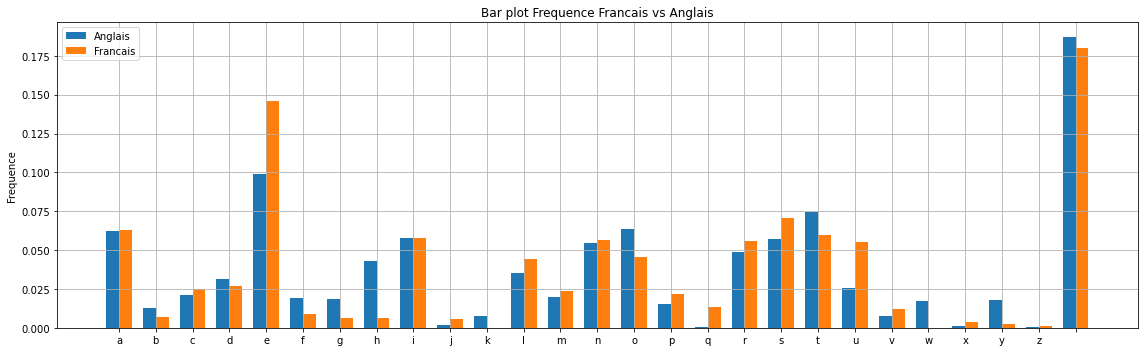

In [22]:

x = np.arange(len(letters_space))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (16,5))
rects1 = ax.bar(x - width/2, frequenceUnigramEn.values[0], label='Anglais', width = width)
rects2 = ax.bar(x + width/2, frequenceUnigramFr.values[0], width = width, label='Francais')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequence')
ax.set_title('Bar plot Frequence Francais vs Anglais')
ax.set_xticks(x)
ax.set_xticklabels(letters_space)
ax.legend()
plt.grid()
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


L'interpretation dépend fortement de la base de texte utilisé. Au  vu de notre base des textes, on constate qu'il y a plus de 'e', 'l', 'u', dans les textes francais que des textes anglais. Ce qui est resultat qui nous surprend. Inversement, les 'h', 'w', 'h', 'y' et 't' sont très plus fréquents dans les textes. On voit que que la log fréquences des lettres 'k', 'w' est quasi- nulle sur notre échantillon de texte en francais ce qui n'est pas surprenant au vu du nombre du faibles nombres de mots qui contient ces caractères en francais officiel [538 pour 'w' et '1625' pour 'k'](https://www.motsavec.com/search.php?m=w) sur les 103000 mots de langue francais (source : [même site](https://www.motsavec.com/search.php?m=w)), contre [73106 pour 'w' et '77911' pour k](https://www.thefreedictionary.com/words-containing-w) en anglais sur les 270000 courants de la langue.  

## **EXERCICE N°2**

#### **1. Estimation des moyennes $\mu_{Fr}$, et $\mu_{An}$ et des variances $\sigma_{Fr}$ et $\sigma_{An}$ des classes.**


L'estimation de paramètres est fait de tel que:

Soit $k \in \{Fr, An\}$, 

$\mathbf{x_i}$ vecteur de $\log(1+freq)$ des lettres du texte $i$,

$y_i$ la classe du texte $i$

$N_k$ le nombre de texte de classe $k$. 

$$\pi_k= \frac{1}{N_k} \sum_{i=1}^N \mathbb{1}(y_i = k) $$ 
$$ \mathbf{\mu_k} = \frac{1}{N_k} \sum_{\substack{i \in \{1,..,N_k\} \\ y_i = k}} x_{i} $$ $$
\sigma_k^2 = \frac{1}{N_k} \sum_{\substack{i \in \{1,..,N_k\} \\ y_i = k}} (x_i - \mu_k)^2$$



In [23]:
# Moyennes 
def estimatorParam(x, y):
    classes = sorted(np.unique(y),reverse= True)
    output = {}

    #output = {'priors' : {},
            # 'means' : {},
            # 'variances' : {}}
            
    X =  matriceX(x, y) # matrice de frequence pour chaque texte
    nbreClasses = len(classes)
    for i in range(nbreClasses):
        output[str(classes[i])]=  {}
    #Initialisation  
    priors = np.empty(nbreClasses)
    means = np.zeros((27,nbreClasses))
    variances = np.zeros((27,nbreClasses))
    for i in range(nbreClasses): 
        index = np.where(y==classes[i])[0]
        #Priors
        output[str(classes[i])]['prior'] = len(index)/len(y)
        #Moyennes
        output[str(classes[i])]['mean'] = np.array([np.mean(X[index,j]) for j in range(27)])
        #Variances
        output[str(classes[i])]['variance'] = np.array([(np.std(X[index,j]))**2 for j in range(27)])
    return  output

In [24]:
params = estimatorParam(liste_texte['textes'].to_frame(),liste_texte['lang'])

In [27]:
params['Anglais']['mean']
d = {'Mean.English': params['Anglais']['mean'], 
     'Mean.French': params['Francais']['mean'], 
     'Variance.English': params['Anglais']['variance'], 
     'Variance.Français': params['Francais']['variance']}
A = pd.DataFrame(d)
A.index = letters_space 
A.head(6)

,Mean.English,Mean.French,Variance.English,Variance.Français
a,0.057197,0.063681,0.000101,0.000059
b,0.012509,0.009364,0.000016,0.000027
c,0.020476,0.024358,0.000036,0.000022
d,0.030342,0.026506,0.000042,0.000034
e,0.092614,0.126923,0.000060,0.000317
f,0.019699,0.009792,0.000016,0.000011


In [26]:
pd.DataFrame(params)

,Francais,Anglais
prior,0.5,0.5
mean,"[0.06368142839833328, 0.009363809911343607, 0....","[0.05719697409384461, 0.012508972942707707, 0...."
variance,"[5.888790923145769e-05, 2.699916876788872e-05,...","[0.00010129315522846193, 1.5760778281695216e-0..."


#### **2. Programmation Classifieur de Bayes**
L'algorithme se base sur la formule de Bayes. On cherche à calculer : 

$$\mathbb{P}(y_i = k | x_i) = \frac{\mathbb{P}(y_i=k)\mathbb{P}(x_i | y_i=k)}{\mathbb{P}(x_i)}$$

On fait l'hypothèse que $(x_i| y_i = k)_{i}$ sont des variables aléatoires indépendantes i.i.d suivant des lois normales de moyennes $\mu_k$  et de variances $\sigma_k^2$ .

- `posteriorBayes` calcule la $\mathbb{P}(y_i=k)\mathbb{P}(x_i | y_i=k)$
- `predictBayes` utilise `posteriorBayes` pour calculer les proba à posteriori pour toutes les classes et retourne la classe qui maximise cette proba


In [28]:
def posteriorBayes(x, parameters):
    obs = freqUnigrams(x).values[0]
    #Calculate Probabilities
    
    variance = parameters['variance']
    mean = parameters['mean']
    prior =  parameters['prior']
    
    covariance = np.diag(variance)
    probability = multivariate_normal.pdf(obs, mean, covariance)
    #Calculate posterior
    posterior = prior * probability
    return posterior

def predictBayes(test, parameters):
    '''
    test :  chaine de caractères  ou un dataframe
    parameters : un dict dont les cles sont "variance", "mean", "prior"
    '''
    if type(test) == str:
        test = pd.DataFrame(np.array([test]))
    
    proba = {}
    for key, _ in parameters.items():
        #print(key)
        params= parameters[key]
        #print(test)
        proba[key] = posteriorBayes(test, params)
    pred = max(proba.items(), key = lambda k : k[1])[0]
    return pred

In [29]:
i = 39#random.randint(0,39)
text_predicts = liste_texte['textes'][i]
{'pred' : predictBayes(text_predicts, params),'true' : liste_texte['lang'][i]}

{'pred': 'Anglais', 'true': 'Anglais'}

#### **3. Evaluation des performances par validation croisée.**

Comme critère de performance on choisi :  'accuracy', 'precision', 'f1' et 'recall'. Ces mesures sont résumer à travers la fonction `scoring_function`.

On définit la function `scoreBayes` qui prend entrée: la liste des textes, le label et les paramètres ($\mu$, $\sigma$ necessaire à la prediction).

La fonction `CV_kfold_bayes` realise la cross validation en utilisant les k fold.


In [30]:
def scoring_function(y_true, y_pred):
    from sklearn import metrics
    accuracy = metrics.accuracy_score(y_true=y_true,y_pred=y_pred)
    precision = metrics.precision_score(y_true=y_true, y_pred=y_pred, average="binary", pos_label=y_true[0])
    f1_score = metrics.f1_score(y_true=y_true,y_pred=y_pred, average="binary", pos_label=y_true[0])
    recall = metrics.recall_score(y_true=y_true,y_pred=y_pred, average="binary", pos_label=y_true[0])
    perf = {'accuracy' : accuracy,'precision' : precision,
           'f1_score' : f1_score, 'recall' : recall}
    return perf

def scoreBayes(liste_texte,labels, parameters):
    '''
    liste_texte : data_frame contenant la liste des textes
    
    labels : langues de chaque texte
    
    parametres :  dict dont les cles sont "variance", "mean", "prior"
    
    '''
    n = len(labels)
    #print(n)
    y_pred = []
    #test_ = pd.DataFrame(np.array([liste_texte['textes'][10]]))
    for j in range(n):
        #print(j)
        texte_j= pd.DataFrame(np.array([liste_texte.iloc[j]]))
        y_pred.append(predictBayes(texte_j, parameters))
    #print(len(y_pred))
    perf = scoring_function(labels, y_pred)
    return perf

def CV_kfold_bayes(X,n_splits = 3, shuffle = True):
    '''
    X : dataframe 2 columns :  textes et lang (ou label)
    
    n_splits : int qui definit le nombre de fold
    
    shuffle : bool condition si on shuffle ou pas le dataset avant les kfold
    '''
    
    perf_test, perf_train = {}, {}
    from sklearn.model_selection import KFold
    kf = KFold(n_splits= n_splits,shuffle=shuffle)
    j = 0
    for train_index, test_index in kf.split(X):
        #print(j)
        X_train, X_test = X['textes'][train_index], X['textes'][test_index]
        y_train, y_test = X['lang'][train_index], X['lang'][test_index]
        #print(X_train.shape)
        params = estimatorParam(X_train.to_frame(),y_train)
        perf_train[j] = scoreBayes(X_train,list(y_train), params)
        perf_test[j] = scoreBayes(X_test,list(y_test), params)
        j +=1 
    return {'test' : perf_test,
           'train' : perf_train}


In [35]:
CV_kfold_bayes(liste_texte, n_splits=5)

{'test': {0: {'accuracy': 1.0,
   'precision': 1.0,
   'f1_score': 1.0,
   'recall': 1.0},
  1: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  2: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  3: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  4: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0}},
 'train': {0: {'accuracy': 1.0,
   'precision': 1.0,
   'f1_score': 1.0,
   'recall': 1.0},
  1: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  2: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  3: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0},
  4: {'accuracy': 1.0, 'precision': 1.0, 'f1_score': 1.0, 'recall': 1.0}}}

Notre classifier arrive à parfaitement prédire nos données. On pense que c'est parce que textes  utilisés sont assez grande pour que l'algorithme voit suffisament de caratères dont la fréquence est representative de la langue. Pour rentre cela challengeant on a chercher à editer des textes couts qui pourrait tromper l'algorithmes. En voici un : 'I really appreciate.'

In [ ]:
text_predicts1 = "I really appreciate"
text_predicts2 = "I really appreciate you"

{text_predicts1 : predictBayes(text_predicts1, params),
text_predicts2 : predictBayes(text_predicts2, params)}

{'I really appreciate': 'Francais', 'I really appreciate you': 'Anglais'}

L'alogrithme predit 'Francais' alors que c'est de l'anglais. Cependant lorsqu'on donne 'I really appreciate you', il parvient à dire prédire la bonne langue.

## **EXERCICE N°3**

Pour des raisons pratiques on notes : 

In [36]:
all_text = liste_texte['textes']
y_lang = liste_texte['lang']

text_fr = liste_texte['textes'][liste_texte['lang'] == 'Francais'] ## listes des textes en francais
text_en = liste_texte['textes'][liste_texte['lang'] == 'Anglais'] ## listes des textes en anglais

y_fr = liste_texte['lang'][liste_texte['lang'] == 'Francais'] ## listes des labels en francais
y_En = liste_texte['lang'][liste_texte['lang'] == 'Anglais'] ## listes des labels en Anglais

#### **1. Estimations des Probabilités des Etats Initiales et des Matrices de Transitions**

Dans l'optique de calculer ces matrices nous avons crée une fonction `transitionMatrix` qui prends en entrée des lignes de textes et donne en sortie une matrice de transition. En effet elle procede dans un premier par transformer ces lignes de textes en une liste de symbole et en suite une prémière liste fille est obtenue en ajoutant un espace au debut de la liste mère et  une deuxième liste fille est obtenue en ajoutant un espace à la fin de la liste mère. 

`estimatorParamMarkov` prent entrée une liste de texte, la liste de label correspond et calcule les probabilités initiales $\pi_k$ et les matrices de transition $A_k$ pour chaque état $k$


In [37]:
def transitionMatrix(text):
    n = len(text)
    #Ligne decomposant liste en une liste de succesion de symboles qui se commence par un espace
    symb1 = np.transpose(transTokeNorm(text, ajoutespace = "d"))
    #Ligne decomposant liste en une liste de succesion de symboles qui se termine par un espace
    symb2 =  np.transpose(transTokeNorm(text, ajoutespace = "f"))
    tran = pd.crosstab(symb2, symb1) + 1 #Attention à l'ordre des parametres.
    transi = pd.DataFrame(np.ones((27,27)))
    transi.index = letters_space
    transi.columns = letters_space
    for letteri in letters_space:
        for letterj in letters_space:
            if (letteri in tran.index)&(letterj in tran.columns):
                transi.loc[letteri, letterj] = tran.loc[letteri, letterj]
    return transi.apply(lambda x: x/np.sum(x), axis=1)

def estimatorParamMarkov(x, y):
    """
    INPUT
    ------
    x : type = 'string'
        Le(s) texte(s) à utiliser
    y : type = 'numpy.array'
        Vecteur labels
    OUTPUT
    ------
    Les estimateurs des paramètres  de la chaine de Markov pour chaque classe.
    Pi_: type = 'numpy.array'
        Probabilité des etats initiaux.
    A_: type = 'numpy.matrix'
        Matrice de transition.
    """
    Pi = {}
    A = {}
    Classes = np.unique(y)
    nbreClasses = len(Classes)
    nbreCaracteres = len(np.unique(transTokeNorm(x))) 
    """# Initialisation
    Pis_en  = np.empty(nbreCaracteres)
    Pis_fr  = np.empty(nbreCaracteres)
    A_en = np.zeros((27, 27))
    A_fr = np.zeros((27, 27))  """  
    # Estimations
    for i in Classes : 
        index = np.where(y == i)
        Pi[i] = freqUnigrams(x.iloc[index])
        A[i] = transitionMatrix(x.iloc[index])
    return A, Pi

In [103]:
A,Pi = estimatorParamMarkov(all_text, y_lang)

In [104]:
pd.DataFrame(A['Anglais']).head(10) # matrice de transition anglais

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
a,0.000764,0.021390,0.049656,0.022154,0.082506,0.016043,0.012987,0.082506,0.012223,0.004584,...,0.066463,0.027502,0.033613,0.006875,0.005348,0.066463,0.001528,0.001528,0.001528,0.317800
b,0.076389,0.017361,0.003472,0.003472,0.020833,0.003472,0.003472,0.013889,0.017361,0.003472,...,0.020833,0.003472,0.010417,0.034722,0.003472,0.003472,0.003472,0.006944,0.003472,0.663194
c,0.128821,0.002183,0.006550,0.004367,0.102620,0.002183,0.002183,0.002183,0.150655,0.002183,...,0.019651,0.058952,0.019651,0.048035,0.002183,0.002183,0.010917,0.006550,0.002183,0.310044
d,0.070149,0.001493,0.001493,0.022388,0.200000,0.001493,0.001493,0.001493,0.049254,0.001493,...,0.055224,0.001493,0.001493,0.019403,0.001493,0.001493,0.001493,0.001493,0.001493,0.168657
e,0.001938,0.031492,0.026163,0.038760,0.030039,0.019864,0.024225,0.203488,0.019864,0.005814,...,0.120640,0.043605,0.064922,0.008721,0.057655,0.022771,0.001938,0.008236,0.002907,0.037306
f,0.018779,0.002347,0.002347,0.002347,0.039906,0.042254,0.004695,0.002347,0.096244,0.002347,...,0.014085,0.004695,0.007042,0.016432,0.002347,0.004695,0.002347,0.009390,0.002347,0.373239
g,0.057214,0.002488,0.002488,0.017413,0.024876,0.002488,0.017413,0.002488,0.087065,0.002488,...,0.019900,0.002488,0.004975,0.094527,0.002488,0.002488,0.002488,0.004975,0.002488,0.161692
h,0.003279,0.001093,0.075410,0.002186,0.005464,0.001093,0.064481,0.001093,0.001093,0.001093,...,0.002186,0.054645,0.534426,0.001093,0.001093,0.072131,0.001093,0.001093,0.001093,0.146448
i,0.027961,0.015625,0.013980,0.034539,0.018914,0.032895,0.010691,0.077303,0.000822,0.000822,...,0.068257,0.052632,0.105263,0.006579,0.016447,0.045230,0.000822,0.006579,0.001645,0.259046
j,0.017544,0.052632,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,...,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.017544,0.456140


In [105]:
pd.DataFrame(A['Francais']).head(10) # matrice de transition francais

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
a,0.001086,0.011944,0.028773,0.030945,0.022801,0.040174,0.016830,0.024430,0.007600,0.015744,...,0.108578,0.044517,0.070575,0.016287,0.030945,0.000543,0.001629,0.007058,0.001086,0.207383
b,0.143478,0.004348,0.004348,0.004348,0.026087,0.004348,0.004348,0.004348,0.069565,0.004348,...,0.060870,0.004348,0.004348,0.043478,0.004348,0.004348,0.004348,0.004348,0.004348,0.386957
c,0.077333,0.001333,0.014667,0.001333,0.125333,0.001333,0.001333,0.001333,0.033333,0.001333,...,0.040000,0.014667,0.005333,0.030667,0.001333,0.001333,0.005333,0.001333,0.001333,0.505333
d,0.017370,0.001241,0.001241,0.001241,0.022333,0.001241,0.001241,0.001241,0.029777,0.001241,...,0.037221,0.001241,0.001241,0.009926,0.001241,0.001241,0.001241,0.001241,0.001241,0.732010
e,0.000470,0.008692,0.049096,0.106883,0.010571,0.007517,0.016913,0.015269,0.047921,0.019027,...,0.114635,0.069298,0.076110,0.061546,0.026075,0.000235,0.001175,0.003759,0.001409,0.102420
f,0.041522,0.003460,0.003460,0.003460,0.096886,0.076125,0.003460,0.003460,0.034602,0.003460,...,0.041522,0.006920,0.003460,0.031142,0.003460,0.003460,0.003460,0.003460,0.003460,0.557093
g,0.173709,0.004695,0.004695,0.004695,0.122066,0.004695,0.004695,0.004695,0.089202,0.004695,...,0.070423,0.004695,0.004695,0.056338,0.004695,0.004695,0.004695,0.004695,0.004695,0.244131
h,0.004902,0.004902,0.568627,0.019608,0.009804,0.004902,0.004902,0.004902,0.004902,0.004902,...,0.004902,0.004902,0.009804,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.142157
i,0.210961,0.010018,0.021803,0.041249,0.020625,0.017678,0.013553,0.012964,0.000589,0.002946,...,0.071892,0.065999,0.073070,0.105480,0.038303,0.000589,0.008839,0.000589,0.000589,0.058928
j,0.005076,0.015228,0.005076,0.005076,0.030457,0.005076,0.005076,0.005076,0.005076,0.005076,...,0.005076,0.005076,0.005076,0.106599,0.005076,0.005076,0.005076,0.005076,0.005076,0.715736


In [106]:
Pii = pd.DataFrame({'Francais' : Pi['Francais'].to_numpy()[0],'Anglais' : Pi['Anglais'].to_numpy()[0], 'index' : letters_space})
Pii.set_index('index').head(10)

,Francais,Anglais
index,,
a,0.062709,0.062137
b,0.007044,0.012689
c,0.025001,0.020922
d,0.026935,0.031189
e,0.146103,0.098702
f,0.009082,0.019372
g,0.006457,0.018210
h,0.006147,0.043055
i,0.057702,0.057633


#### **2.Programmation du classifieur markovien**

Le modèle se base la vraisemblance des données: On cherche $k \in \{Ang, Fra\}$ tel que:

$$ \underset{x}{\operatorname{argmax}} \mathbb{P}(x_{1:T} | \mathbf{\theta} = A_{k}, \pi_{k}) = \underset{x}{\operatorname{argmax}} \pi_k(x_1)A_{k}(x_1,x_2)...A_{k}(x_{T-1,T}) $$

In [107]:
def PosteriorMarkov(x, Pi, A):
    """
    INPUT:
    -----
    x : str 
    Pi : array proba des états initiaux
    A : matrice de transistion
    OUTPUT
    -------
    La probabilité à posteriori
    """
    mot = transTokeNorm(x)
    n = len(mot)
    #print(mot[235:245])
    indices = []
    indices = np.array([letters_space.index(mot[i]) for i in range(n)])
    #for i in range(n):
        #print(i)
        #indices.append(letters_space.index(mot[i]))
    probaInit = Pi[mot[0]].values[0]
    for i in range(n-1):
        posterior = probaInit*A.loc[mot[i+1],mot[i]]
    return posterior

def predictMarkov(test, A, Pi):
    '''
    testt : 'str'
    A : Matrice de transition
    Pi : proba des états initiaux
    '''
    if type(test) == str:
        test = pd.DataFrame(np.array([test]))
    
    proba = {}
    for key,_ in Pi.items():
        #print(test)
        proba[key] = PosteriorMarkov(test, Pi[key], A[key])
    pred = max(proba.items(), key = lambda k : k[1])[0]
    return pred

In [108]:
A,Pi = estimatorParamMarkov(all_text, y_lang)

In [109]:
i = random.randint(0,39)
text_predicts = liste_texte['textes'][i]
{'pred' : predictMarkov(text_predicts,A,Pi),'true' : liste_texte['lang'][i]}

#text_predicts = "Je m'appelle Sam, étudiant en ecole d'ingénieur" #all_text.iloc[]
#text_predicts = pd.DataFrame(np.array([text_predicts]))


{'pred': 'Francais', 'true': 'Francais'}

In [110]:
# voir sur quelles textes l'algorithmes se trompent

#i = random.randint(0,39)
for i in range(40):
    text_predicts = liste_texte['textes'][i]
    if(predictMarkov(text_predicts,A,Pi) != liste_texte['lang'][i]):
        print("erreur de prediction sur les textes {} qui est texte {}".format(i,liste_texte['lang'][i]))

#text_predicts = "Je m'appelle Sam, étudiant en ecole d'ingénieur" #all_text.iloc[]
#text_predicts = pd.DataFrame(np.array([text_predicts]))


erreur de prediction sur les textes 8 qui est texte Francais
erreur de prediction sur les textes 11 qui est texte Francais
erreur de prediction sur les textes 20 qui est texte Anglais
erreur de prediction sur les textes 31 qui est texte Anglais
erreur de prediction sur les textes 33 qui est texte Anglais
erreur de prediction sur les textes 38 qui est texte Anglais
erreur de prediction sur les textes 39 qui est texte Anglais


Contrairement au Classifier Naives Bayes, qui ne faisait pas d'erreur sur les données de la bases de textes. Le Classifier Markovien, fait des erreurs sur les textes 8,11,20,31,33,38 et 39. Etudions les performances de notre Algorithmes par cross

#### **3. Evaluation des performances par validation croisée.**

Comme critère de performance on choisi :  'accuracy', 'precision', 'f1' et 'recall'. Ces mesures sont résumer à travers la fonction `scoring_function`.

On définit la function `scoreMarkov` qui prend entrée: la liste des textes, le label et la matrice de transition a et les proba des états initiaux Pi.

La fonction `CV_kfold_Markov` realise la cross validation en utilisant les k fold.


In [111]:
def scoreMarkov(liste_texte,labels, A,Pi):
    #n = len(labels)

    
    '''
    liste_texte : data_frame contenant la liste des textes
    
    labels : langues de chaque texte
    
    A : matrice de transition
    
    Pi : proba des états initiaux
    
    '''
    n = len(labels)
    #print(n)
    y_pred = []
    #test_ = pd.DataFrame(np.array([liste_texte['textes'][10]]))
    for j in range(n):
        #print(j)
        texte_j= pd.DataFrame(np.array([liste_texte.iloc[j]]))
        y_pred.append(predictMarkov(texte_j, A,Pi))
    #print(len(y_pred))
    perf = scoring_function(labels, y_pred)
    return perf

def CV_kfold_Markov(X,n_splits = 3, shuffle = True):
    
    '''
    X : dataframe 2 columns :  textes et lang (ou label)
    
    n_splits : int qui definit le nombre de fold
    
    shuffle : bool condition si on shuffle ou pas le dataset avant les kfold
    '''
    
    perf_test, perf_train = {}, {}
    from sklearn.model_selection import KFold
    kf = KFold(n_splits= n_splits,shuffle=shuffle)
    j = 0
    for train_index, test_index in kf.split(X):
        #print(j)
        X_train, X_test = X['textes'][train_index], X['textes'][test_index]
        y_train, y_test = X['lang'][train_index], X['lang'][test_index]
        #print(X_train.shape)
        A,Pi = estimatorParamMarkov(X_train, y_train)
        perf_train[j] = scoreMarkov(X_train,list(y_train), A,Pi)
        perf_test[j] = scoreMarkov(X_test,list(y_test), A,Pi)
        j +=1 
    return {'test' : perf_test,
           'train' : perf_train}


In [112]:
resulat_cv = CV_kfold_Markov(liste_texte, n_splits=5)

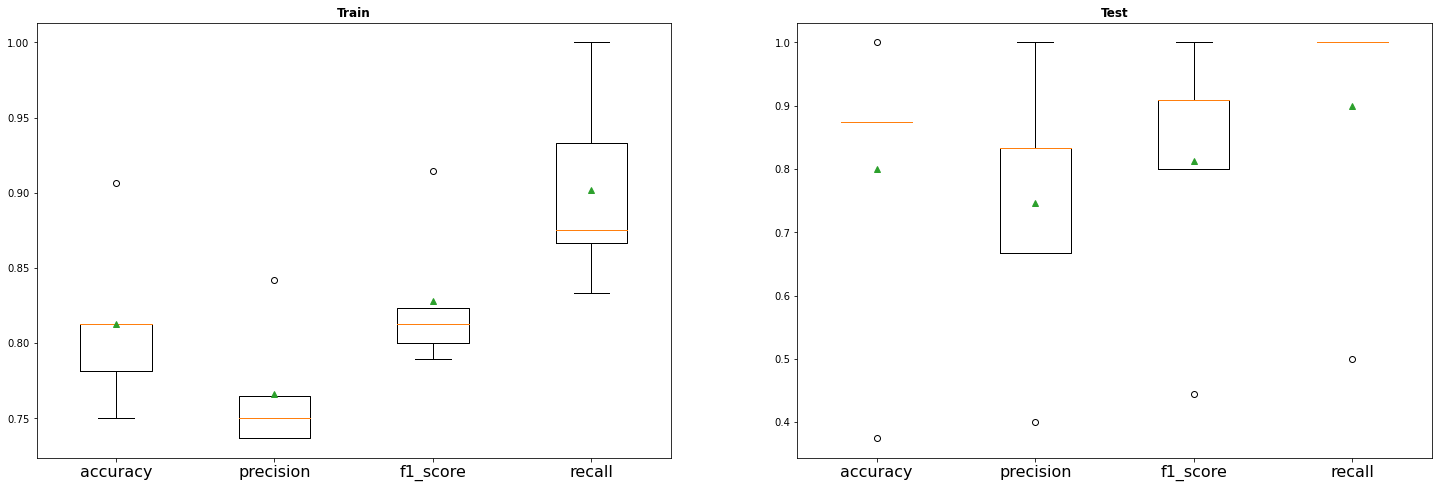

In [113]:
res_cv_test = pd.DataFrame(resulat_cv['test']).T
res_cv_train = pd.DataFrame(resulat_cv['train']).T

plt.figure(figsize=(25,8))
ax = plt.subplot(121)
ax.boxplot(res_cv_train,labels = list(res_cv_train.columns),showmeans=True)
ax.set_title('Train', 
             fontweight ="bold")
plt.xticks(fontsize=16)
ax = plt.subplot(122)
ax.boxplot(res_cv_test,labels = list(res_cv_test.columns),showmeans=True)
ax.set_title('Test', 
             fontweight ="bold")
plt.xticks(fontsize=16)
plt.show()

In [114]:
pd.DataFrame(resulat_cv['test']).T

,accuracy,precision,f1_score,recall
0,0.875,0.833333,0.909091,1.0
1,0.375,0.400000,0.444444,0.5
2,0.875,0.666667,0.800000,1.0
3,0.875,0.833333,0.909091,1.0
4,1.000,1.000000,1.000000,1.0


In [115]:
pd.DataFrame(resulat_cv['train']).T

,accuracy,precision,f1_score,recall
0,0.81250,0.764706,0.812500,0.866667
1,0.90625,0.842105,0.914286,1.000000
2,0.75000,0.750000,0.789474,0.833333
3,0.81250,0.736842,0.823529,0.933333
4,0.78125,0.736842,0.800000,0.875000


On remarque que les performances restent globalement entre le train et le test des cross validation. Cependant comme montrer plutôt les performances de notre modèle markovien sont moins que Naives bayes sur notre ensemble de textes. Sur le court texte "I really appreciate" Markov predit comme Naives Bayes

In [116]:
text_predicts1 = "I really appreciate"
text_predicts2 = "I really appreciate you"

{text_predicts1 : predictMarkov(text_predicts1, A,Pi),
text_predicts2 : predictMarkov(text_predicts2, A,Pi)}

{'I really appreciate': 'Francais', 'I really appreciate you': 'Anglais'}

## **EXERCICE 4 : Décodage de langue par Viterbi**

#### **1-texte d'au plus 1000 caractères enchaînnant de manière aléatoire des phrase en français et en anglais tirées de vos textes initiaux.**

Pour créér ce court texte, on a creer une courte fonction `generate_texte` qui prend en paramètre la liste de texte, et un nombre limite
de caractère `nchar`. Cette fonction selection un texte aléatoirement. Puis dans ce texte, elle selection une phrase prises aléatoirement aussi et la concatène à une chaine de caratère initialement vide. Ce processus est repété tant que la longueur de la chaine de caractère ainsi créer est reste inférieure à `nchar`.


In [117]:
def generate_texte(text = all_text,label = y_lang, nchar = 1000):
    '''
    generate prend entree le dataframe contenant tous les tetxes. Selectionne aléatoirement un indice de ligne. 
    
    Cette indice represente un texte. Ce texte est decomposé en phrase, et on selectionne aleatoirement une phrase*
    
    dans l'ensemble des phrases de textes. Le tout est stocké dans un nouveau data frame dont chaque ligne est une phrase, et 
    
    en parallèle on contruit une chaine de caractère contenant cette enchainement aléatoire de textes.
    ----------------------------------------------------------------------------------------------
    input : 
        text :  dataframe contenant un ensemble de textes.
        
        label : liste des langues de textes ou codages des langues 
        
        nchar : nombre maximales de caractères dans textes générés.
        
    outputs : 
        text_gen : str texte généré 
        df_text_gen :  dataframe dont les lignes sont les phrases du texte generé. les colunnes 'text' et 'lang'
        nbre_char : int nombre de caratères.
        
    
    '''
    df_generated_text =[]# 
    label_gen = []
    texte_gen = ""
    n = len(text)
    nbre_char = 0
    while True: #(nbre_char < nchar):
        i = random.randint(0,n-1) # index du texte entre 0 et n-1
        random_text = text[i]
        #print(i)
        random_text = re.split(r' *[\.\?!][\'"\)\]]* *', random_text) # conversion en liste de phrases
        random_sentence = random.choices(random_text)[0] #+ ". "
        nbre_to_add = len(transTokeNorm(random_sentence))
        nbre_possible = (nchar-nbre_char)
        #print(nbre_to_add)
        #print(nbre_possible)
        if (nbre_to_add > nbre_possible):
            #df_generated_text.pop()
            #label_gen.pop()
            #texte_gen = re.split(r' *[\.\?!][\'"\)\]]* *', texte_gen)
            #texte_gen.pop()
            break
        elif ((random_sentence != "")):
            df_generated_text = df_generated_text + [random_sentence]#generated_text + random_sentence
            texte_gen+=  random_sentence+ "."
            label_gen += [label[i]]
            nbre_char+=nbre_to_add

    #print(generated_text)
    #pd.DataFrame({'text' : generate_texte(), })
    df_text_gen = pd.DataFrame({'text' : df_generated_text,
                           'lang' : label_gen})
    return texte_gen, df_text_gen, nbre_char
    

In [147]:
random.seed(115)
text_gen, df_text_gen, nombre_char = generate_texte() ## generation du texte avec des passsages en anglais et en francais
print('il y a : ',Counter(df_text_gen['lang'])) # nbre de texte en francais vs nbre de texte en anglais
print('Il y a {} caractères.'.format(nombre_char))

il y a :  Counter({'Francais': 6, 'Anglais': 6})
Il y a 920 caractères.


In [148]:
print(text_gen) # texte générer

Y a
t-on réussi.
Au bout du petit matin, cette ville plate étalée.this was shot generationally
or by degree, a quotient of time, drawn
up by the window with you excluded,
you emended from classification.qui le manifestent.Aftershock and jaw-ache,
a stranger wandering a house in tightening circles.
They call her a young country, but they lie:
She is the last of lands, the emptiest,
A woman beyond her change of life, a breast
Still tender but within the womb is dry.L’énergie reçue
par m² dépend de l’angle des rayons solaires par rapport au sol.
you could cut your foot on that accurate division.Mais le père fut sage
De leur montrer avant sa mort
Que le travail est un trésor.There’s not a word from feathers or thinly shaped bones
brought about by crashing through muddy grounds.Foudroyés aujourd'hui
par la force mécanique, nous pourrons vaincre dans l'avenir par une force mécanique
supérieure.The Only White Landscape is an assembly point.


#### **2- Algorithme de Viterbi pour trouver les passages en français et en anglais.**

Pour cet algorithme, nous avons besoins d'une matrice d'émission des observations, d'une matrice de transition d'une langue à l'autre et des proportions de chaque classe dans l'ensemble des données.
La matrice d'émission sera obtenue en calculant les probabilités stationnaires à partir des matrices de transition entre lettres obtenue à l'exercice précédent.
La matrice de transition d'une langue à l'autre sera fixée. A ce niveau, nous fixons à 95% la probabilité de passer de l'anglais à l'anglais et à 5% la chance de passer de l'anglais au français. Egalement, les mêmes probabilités sont fixées pour la transition du français vers le français et du français vers l'anglais respectivement.
Pour finir, au texte aléatoire créer, nous avons créer un vecteur de labels correspondant, question de les comparer avec les labels prédits par Viterbi.

In [127]:
import numpy.linalg as alg
def Viterbi(X,A_etats, B,Pi):
    import numpy as np
    K = len(A_etats)
    T = len(X)
    #print(K)
    print(T)
    S = np.zeros((K, T))
    logV =  -np.inf*np.ones((K, T))
    Ztest = np.repeat(0, T)
    for k in range(K):  
        #print(X[0])
        logV[k,0] = np.log(B[letters_space.index(X[0]), k]) + np.log(Pi[k])
        S[k, 0] = 0
    #Forward
    for t in range(1,T):
        for k in range(K):
            logV[k, t] = np.max(logV[:,t-1] + np.log(A_etats[:,k]).T + np.log(B[letters_space.index(X[t]),k])) 
            S[k,t-1] = np.argmax(logV[:,t-1] + np.log(A_etats[:,k]).T + np.log(B[letters_space.index(X[t]), k]))
    # Backward
    Ztest[T-1] = np.argmax(logV[:,T-1])
    for t in range((T-2),0, -1):
        Ztest[t] = S[Ztest[t+1],t]
    res = list(map(lambda x: 'Francais' if x==-1 else 'Anglais', -2*Ztest+1))
    return res

#### **3. Commentaire et test  de l'algotithme**

Pour le test on génére aléatoirement un texte comprenant du francais et de l'anglais. La cellule suivante initialise la proportion des classes $\pi$ noté `Pi`, la matrice de Transition des états `A_etats` et la matrice d'emissions `B` de caractères. On tient à noter que B est de tailles 27 x 2, et chaque colonne de `B` represente une langue.

Soit $k \in \{Fr, An\}$ . Le calcul du vecteur $B_k = (B_{ik})_{i \in letters_space}$ se fait en resolvant l'équation :

$$B_k = B_k A_{etats} \mbox{   avec } \sum_{i \in letters_{space}} B_{ik} = 1$$

In [140]:
################ generation du texte#########
random.seed(115)
text_gen, df_text_gen, nombre_char = generate_texte() ## generation du texte avec des passsages en anglais et en francais
print('il y a : ',Counter(df_text_gen['lang'])) # nbre de texte en francais vs nbre de texte en anglais
print('Il y a {} caractères.'.format(nombre_char))

############# initialisation des paramètres Pi, A_etats et B ##############
# Algorithme de viterbi
label = np.unique(y_lang)
n_classes = len(label)
# matrice de transition d'une langue à l'autre
A_etats = np.array([[0.95, 0.05], [0.05, 0.95]])

Pi = [1/n_classes]*n_classes  ## Pi

# text aléatoire décomposé en caractères
X1 = transTokeNorm(text_gen)
n_caracteres = 27#len(np.unique(X1))

# Calcul de la matrice d'emission des observations 
A,_ = estimatorParamMarkov(all_text, y_lang)


B = np.zeros((n_caracteres, n_classes))
B = pd.DataFrame(B, columns = ['Anglais', 'Francais'], index = letters_space)#initialisation
##Anglais
#B =B.to_numpy()
for key,_ in A.items():
    #print(key)
    M = np.eye(27) - A[key].to_numpy()
    M[:,-1] = [1]*n_caracteres
    b = [0]*(n_caracteres - 1) + [1]
    B[key] = alg.solve(M.T,b)
B = B.to_numpy()

#B.sum(axis = 0)

il y a :  Counter({'Francais': 6, 'Anglais': 6})
Il y a 920 caractères.


In [141]:
print(text_gen) # texte généré

Y a
t-on réussi.
Au bout du petit matin, cette ville plate étalée.this was shot generationally
or by degree, a quotient of time, drawn
up by the window with you excluded,
you emended from classification.qui le manifestent.Aftershock and jaw-ache,
a stranger wandering a house in tightening circles.
They call her a young country, but they lie:
She is the last of lands, the emptiest,
A woman beyond her change of life, a breast
Still tender but within the womb is dry.L’énergie reçue
par m² dépend de l’angle des rayons solaires par rapport au sol.
you could cut your foot on that accurate division.Mais le père fut sage
De leur montrer avant sa mort
Que le travail est un trésor.There’s not a word from feathers or thinly shaped bones
brought about by crashing through muddy grounds.Foudroyés aujourd'hui
par la force mécanique, nous pourrons vaincre dans l'avenir par une force mécanique
supérieure.The Only White Landscape is an assembly point.


920
Le score viterbi est 86.52 %


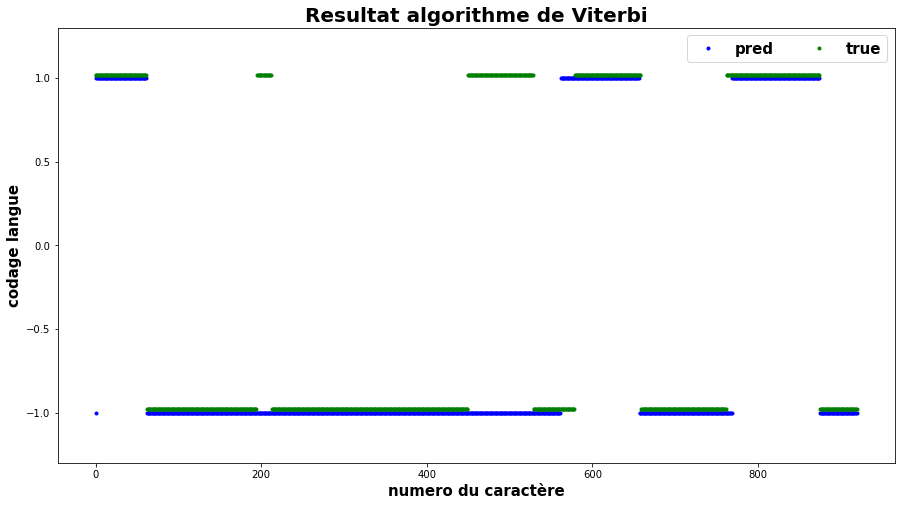

In [142]:
NbreTextes = len(df_text_gen['lang'])
Z = []
for i in range(NbreTextes):
    text_i = transTokeNorm(df_text_gen['text'].iloc[i])
    NbreChar = len(text_i)
    for j in range(NbreChar):
        Z.append(df_text_gen['lang'][i])
#Le vrai MAP
Z = np.array(Z)
#La prediction MAP de viterbi
Zhat = Viterbi(X1, A_etats, B, Pi)
len(Zhat)
len(Z)
score = np.sum(Z==Zhat)/len(Z)
print("Le score viterbi est", np.round(score*100, 2),"%")
res_pred = list(map(lambda x: 1 if x=='Francais' else -1, Zhat))
res_true= list(map(lambda x: 1+0.02 if x=='Francais' else -1+0.02, Z))
import matplotlib.pyplot as plt
legend_properties = {'weight':'bold', 'size' : 15}
plt.figure(figsize=(15,8))
plt.plot(res_pred, 'b.')
plt.plot(res_true, 'g.')
plt.ylim(-1.3,1.3)
plt.xlabel('numero du caractère', fontsize =  15, fontweight = 'bold')
plt.ylabel('codage langue', fontsize =  15, fontweight = 'bold')
plt.title('Resultat algorithme de Viterbi',fontweight ="bold", fontsize = 20)
plt.legend(['pred', 'true'], ncol = 2, fancybox = True, prop = legend_properties)
plt.show()

On observe des bons scores de predictions pour l'algorithmes de Viterbi avec des erreurs qui interviennent essentiellement au niveau des changements d'etats cachés. Ces changements peuvent être visualisés à travers le graphe ci dessus qui présentes les valeurs ressortis par l'algorithmes contre les valeurs réelles des états cachés. Pour des raisons de lisibilité du graphes, on a décaler les valeurs réelles d'un nombre **0.02**. On note également que:
- **-1 represente une séquence en Anglais**
- **1 represente une séquence en Francais**


## **EXERCICE 5 : Algorithme de Baum-Welch**

 #### **1. algorithme de Baum-Welch à deux états cachés.**

Marice de transition A: shape = (2,2)

Matrice d'emission B: shape = (nobs,2)

Probabilité des états initiaux Pi: len =2

In [143]:
def baum_welch(x, A, B, Pi, v, epsilon, max_iter, verbose=True):
    Pi_bw = Pi.copy()
    A_bw = A.copy()
    B_bw = B.copy()
    run = 0
    loss = [5]
    T = len(x) #Nombre d'observation
    L = B.shape[0] # Nombre valeur possible  x
    N = B.shape[1] #Nombre d'état chaché (cluster ou classe)
    alpha = np.zeros((N, T), dtype = np.float64)
    beta = np.zeros((N, T), dtype = np.float64)
    gamma = np.zeros((N, T), dtype = np.float64)
    eta = np.zeros((T, N, N), dtype = np.float64)
    #la vraisemlance 
    proba = 0  
    proba_new = 0
    if verbose:
        print("Lauching Baum-Welch solver...")
        print(' | '.join([name.center(8) for name in ["Iteration", "Vraisemblance"]]))    
    while (loss[run]>epsilon)&(run<max_iter): 
        ### Forward
        # Initialisation
        alpha[:,0] = Pi_bw*B_bw[letters_space.index(x[0]),:]
        for t in range(T-1):
            alpha[:,t+1] = B_bw[letters_space.index(x[t+1]),:]*(A_bw.T.dot(alpha[:,t]))
        ### Backward
        # Initialisation
        beta[:,-1] = 1
        for t in range(T-2, -1, -1):
            beta[:,t] = A_bw.dot(B_bw[letters_space.index(x[t+1]),:]*beta[:,t+1])
        ### Actualise la vraisemlance 
        proba_new = proba
        proba = np.sum(alpha[:,T-1])
        loss.append(abs(proba-proba_new))
        ### Calcul de gamma 
        gamma = alpha*beta
        ### Calcul de Eta 
        for t in range(T-1):
            for i in range(N):
                for j in range(N):
                    eta[t,i,j] = alpha[i,t]*B_bw[letters_space.index(x[t+1]),j]*beta[j,t+1]*A_bw[i,j]
                gamma[i,t] = np.sum(eta[t,i,:])
        ### Reestimation
        for i in range(N):
            Pi_bw = gamma[:,0]/proba
            for j in range(N):
                A_bw[i,j] = np.sum(eta[0:T-1,i,j]) / np.sum(gamma[i,0:T-1])
            # Il nous faut un vecteur v_k
            for k in letters_space:
                B_bw[letters_space.index(k), i] = np.sum(gamma[i,x==k]) / np.sum(gamma[i,0:T])
        run = run + 1
        print(' | '.join([("%d" % run).rjust(8), ("%.2e" % proba).rjust(8)]))
    Z_bw = np.array([np.argmax(gamma[:,i]) for i in range(T)])
    Z_bw = -2*Z_bw + 1
    return Z_bw #Pi_bw, A_bw, B_bw, gamma

#### Formule pour estimer les etats cachés

$$\mathbb{P}(z_t = j | x_{1:T}) \propto p(z_t = j|x_{1:t})\times p(x_{t+1:T}|z_t=j)$$
    $$\gamma (j) \propto \alpha_t(j) \times \beta_t(j)$$

In [144]:
epsilon = 1e-5
max_iter = 10
#Nous prenons un sous ensemble de 
X_essai = X1[0:250] 
Z_essai = list(map(lambda x: -1 if x=='Francais' else 1, Z[0:250]))
V = letters_space # les valeurs distinctes de x
Z_bw = baum_welch( X_essai, A_etats, B,Pi,V, epsilon, max_iter)

Lauching Baum-Welch solver...
Iteration | Vraisemblance
       1 | 2.28e-315


#### **Performance** 

In [145]:
score = np.sum(Z_bw==Z_essai)/len(Z_bw)
print("Le score l'algorithme de Baum-Welch exécuté sur les paramètres du texte d'au moins de 200 caractères est de",score*100, "%") 

Le score l'algorithme de Baum-Welch exécuté sur les paramètres du texte d'au moins de 200 caractères est de 75.6 %


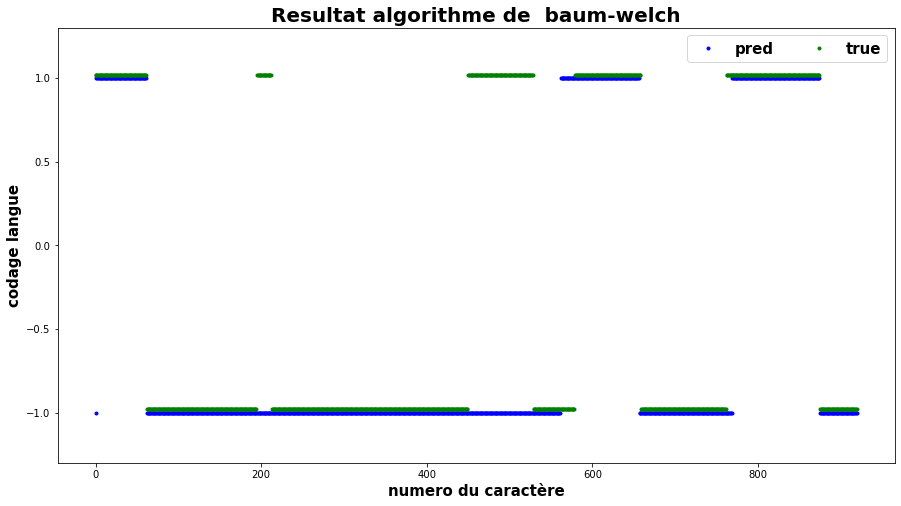

In [146]:

legend_properties = {'weight':'bold', 'size' : 15}
plt.figure(figsize=(15,8))
plt.plot(res_pred, 'b.')
plt.plot(res_true, 'g.')
plt.ylim(-1.3,1.3)
plt.xlabel('numero du caractère', fontsize =  15, fontweight = 'bold')
plt.ylabel('codage langue', fontsize =  15, fontweight = 'bold')
plt.title('Resultat algorithme de  baum-welch',fontweight ="bold", fontsize = 20)
plt.legend(['pred', 'true'], ncol = 2, fancybox = True, prop = legend_properties)
plt.show()